In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from scipy import stats
import time

In [18]:
rhos = [0.1, 0.01, 0.001]
simulations_per_rho = 100
groups_per_sim = int(5e4)
max_steps = int(1e7)

In [19]:
@numba.jit
def simulation(rho=0.1, max_steps=100, runs=1, target_num_groups=10):
    groups = np.zeros((runs, max_steps), dtype=np.int32)
    groups[:, 0] = 1
    next_group_id = np.ones(runs, dtype=np.int32)
    elements = np.zeros((runs, max_steps), dtype=np.int32)
    for run_id in range(runs):
        for idx in range(1, max_steps):
            if np.random.random() < rho:
                curr_element = next_group_id[run_id]
                next_group_id[run_id] += 1
            else:
                copy_id = np.random.randint(idx)
                curr_element = elements[run_id, copy_id]
            elements[run_id,  idx] = curr_element
                
            groups[run_id, curr_element] =  groups[run_id, curr_element] +  1
            if next_group_id[run_id] >= target_num_groups:
                break
        print(run_id, idx)
                    
    return (groups, elements, next_group_id)


In [20]:
_ = simulation(max_steps=int(1e7), target_num_groups=int(5e4), runs=10)

0 499508
1 496253
2 501603
3 500849
4 499983
5 500472
6 497472
7 496231
8 500163
9 502307


In [21]:
results = [None] * len(rhos)
for n in range(len(rhos)):
    t0 = time.time()
    results[n] = simulation(rho=rhos[n], max_steps=max_steps, target_num_groups=groups_per_sim, runs=simulations_per_rho)
    t1 = time.time()
    print("took: %.2f"%(t1-t0))

0 499226
1 498715
2 504043
3 499460
4 496820
5 499963
6 502550
7 499973
8 501124
9 504791
10 502433
11 499228
12 500262
13 503236
14 498623
15 497849
16 501131
17 501094
18 500763
19 501088
20 499856
21 502569
22 498137
23 502191
24 498945
25 498797
26 499674
27 501955
28 500621
29 498447
30 500168
31 502569
32 497801
33 499186
34 500960
35 500750
36 500791
37 499799
38 501927
39 495423
40 500738
41 497408
42 502947
43 499964
44 499013
45 504837
46 497418
47 498208
48 498361
49 503958
50 498752
51 497928
52 496822
53 495531
54 499726
55 502695
56 499882
57 497084
58 497421
59 501046
60 503724
61 496563
62 498216
63 500392
64 500614
65 498448
66 501087
67 503945
68 498758
69 502902
70 503014
71 500748
72 494482
73 497843
74 500958
75 500568
76 501725
77 500853
78 501129
79 502909
80 500284
81 496953
82 497435
83 500092
84 500806
85 498605
86 501444
87 499241
88 500096
89 505650
90 500321
91 502945
92 497771
93 501508
94 500048
95 499759
96 499011
97 502907
98 494565
99 499912
took: 4.94

Rho 0.100. First mover is of size 142200.02 which is 4.75 times bigger than the regression predicts.


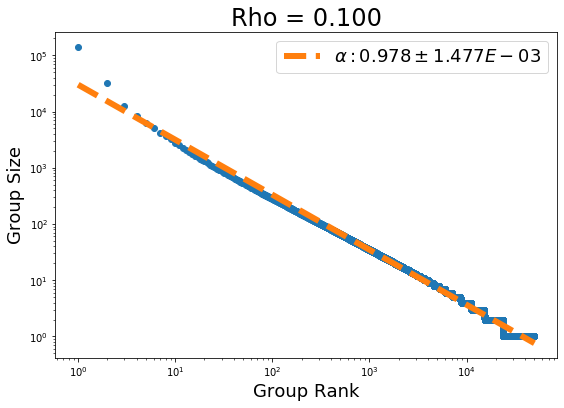

Rho 0.010. First mover is of size 4321617.29 which is 57.75 times bigger than the regression predicts.


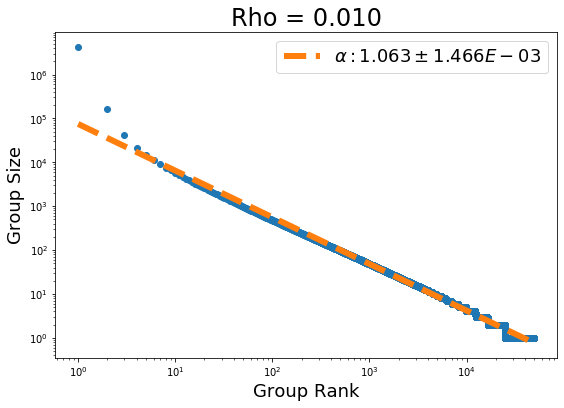

Rho 0.001. First mover is of size 9827659.70 which is 620.56 times bigger than the regression predicts.


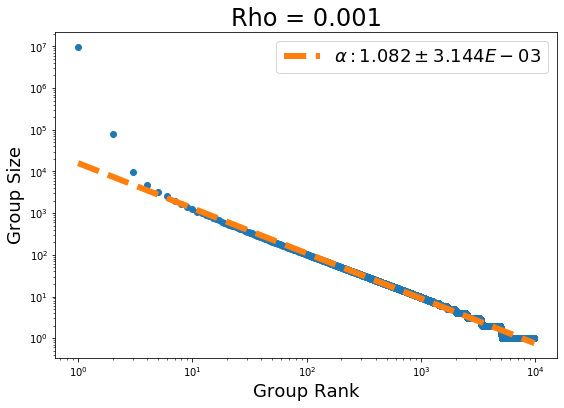

In [24]:
for i in range(len(rhos)):
    tmp = results[i]
    group_counts = tmp[0]
    sorted_groups = np.flip(np.sort(group_counts))
    max_index = np.max(tmp[2]) - 1
    group_means = np.mean(sorted_groups[:, :max_index], axis=0)
    mask = (group_means >=1)
    Y_sub = group_means[mask][1:]
    X_sub = np.arange(1, Y_sub.shape[0] +1)
    log10_X_sub = np.log10(X_sub)
    log10_Y_sub = np.log10(Y_sub)
    slope, intercept, r_val, p_val, std_err = stats.linregress(log10_X_sub, log10_Y_sub)
    predict = lambda n: intercept + slope * n 
    predictions = np.power(10, predict(log10_X_sub))
    
    print("Rho %.3f. First mover is of size %.2f which is %.2f times bigger than the regression predicts."%(rhos[i], group_means[0], group_means[0]/np.power(10, predict(0))))
    
    fig, ax = plt.subplots(1, figsize=(9,6))
    ax.scatter(np.arange(1, Y_sub.shape[0] +2), group_means[mask])
    ax.plot(X_sub, predictions, c="C1", linewidth=6, linestyle="dashed", label=r"$\alpha: %.3f \pm %.3E$"%((-1 * slope), std_err * 1.96))
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(fontsize=18)
    plt.title("Rho = %.3f"%rhos[i], fontsize=24)
    plt.xlabel("Group Rank", fontsize=18)
    plt.ylabel("Group Size", fontsize=18)
    plt.savefig("/Users/David/MATH300/CSYS300-git/Assignment_4/figs/part_2/rho_%s.png"%(str(rhos[i])), bbox_inches="tight", pad_inches=0, dpi=500)
    plt.savefig("/Users/David/MATH300/CSYS300-git/Assignment_4/figs/part_2/rho_%s.pdf"%(str(rhos[i])), bbox_inches="tight", pad_inches=0)
    plt.show()